In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

%matplotlib notebook
plt.rcParams['figure.figsize'] = (5.0, 5.0)

In [2]:
train= pd.read_csv("train.csv")
test =pd.read_csv("test.csv")
response  = train['Response']
train.shape, test.shape

((381109, 10), (127037, 9))

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,0


In [4]:
for i in train.columns:
    if i not in ['id','Region_Code','Annual_Premium','Age']:
        print(train[i].value_counts())
        print('*'*50)
        

Male      206089
Female    175020
Name: Gender, dtype: int64
**************************************************
1    380297
0       812
Name: Driving_License, dtype: int64
**************************************************
0    206481
1    174628
Name: Previously_Insured, dtype: int64
**************************************************
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64
**************************************************
Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64
**************************************************
0    334399
1     46710
Name: Response, dtype: int64
**************************************************


In [5]:
#mapping
gender = {'Male':1,'Female':0}
vehical_age = {'1-2 Year':2,"< 1 Year":1,'> 2 Years':0}
vehical_damage = {'Yes':1,'No':0}

#train_map
train['Gender'] =train['Gender'].map(gender)
train['Vehicle_Damage'] = train['Vehicle_Damage'].map(vehical_damage)
train['Vehicle_Age'] = train['Vehicle_Age'].map(vehical_age)

In [6]:
#feature engineering
train['log_premium'] = train['Annual_Premium'].apply(lambda x: np.log(x))
train['Gender_premium'] = train.groupby(['Gender'])['log_premium'].transform('mean')
train['Vehicle_Damage_premium'] = train.groupby(['Vehicle_Age'])['log_premium'].transform('mean')
train['Gender_premium'] = train.groupby(['Vehicle_Age'])['log_premium'].transform('mean')
train['Vehicle_Age_premium'] = train.groupby(['Vehicle_Age'])['log_premium'].transform('mean')
train['Previously_Insured_premium'] = train.groupby(['Previously_Insured'])['log_premium'].transform('mean')


In [7]:
train['Gender_premium'].value_counts()

9.952826     200316
10.077546    164786
10.141933     16007
Name: Gender_premium, dtype: int64

In [8]:
#train.boxplot(column='Annual_Premium')
#sns.distplot(train['Annual_Premium'])


In [9]:
#plt.figure()
#sns.distplot(train['log_premium'])
train.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,log_premium,Gender_premium,Vehicle_Damage_premium,Vehicle_Age_premium,Previously_Insured_premium
0,1,1,44,1,28,0,0,1,40454,1,10.607921,10.141933,10.141933,10.141933,9.962865
1,2,1,76,1,3,0,2,0,33536,0,10.420375,9.952826,9.952826,9.952826,9.962865


In [36]:
bins = pd.qcut(train['Age'],5,[0,1,2,3,4])
train['Age_bin'] = bins

In [58]:
#Encoding ---One hot
features  =['Age_bin','Gender', 'Previously_Insured','Vehicle_Damage','Vehicle_Age']
for i in features:
    train[i] = train[i].astype('category')
from sklearn.preprocessing import OneHotEncoder
#for col in features:
Ohe =OneHotEncoder()
chk = pd.get_dummies(train[features])
final = pd.concat([train,chk],axis=1)
#train = pd.concat([train,chk],axis=1)
final.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,...,Age_bin_4,Gender_0,Gender_1,Previously_Insured_0,Previously_Insured_1,Vehicle_Damage_0,Vehicle_Damage_1,Vehicle_Age_0,Vehicle_Age_1,Vehicle_Age_2
0,1,1,44,1,28,0,0,1,40454,1,...,0,0,1,1,0,0,1,1,0,0
1,2,1,76,1,3,0,2,0,33536,0,...,1,0,1,1,0,1,0,0,0,1
2,3,1,47,1,28,0,0,1,38294,1,...,0,0,1,1,0,0,1,1,0,0
3,4,1,21,1,11,1,1,0,28619,0,...,0,0,1,0,1,1,0,0,1,0
4,5,0,29,1,41,1,1,0,27496,0,...,0,1,0,0,1,1,0,0,1,0


In [13]:
#model 1_logistic
params = [i for i in train.columns if i not in ['id','Region_Code','Response','Annual_Premium','Age']]
trainx,testx,trainy,testy = train_test_split(train[params],train['Response'],test_size=0.10,random_state=42,shuffle=True)
model = LogisticRegression(C=1,max_iter=2000)

model.fit(trainx,trainy)


LogisticRegression(C=1, max_iter=2000)

In [14]:
model.score(trainx,trainy) #87.71 #87.77

0.8777631356451058

In [15]:
model.score(testx,testy)  #87.28 #87.45

0.874498176379523

In [16]:

predict = model.predict(testx)
print(classification_report(testy,predict))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     33328
           1       0.00      0.00      0.00      4783

    accuracy                           0.87     38111
   macro avg       0.44      0.50      0.47     38111
weighted avg       0.76      0.87      0.82     38111



c:\users\rohit joshi\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
pickle.dump(model,open("model.pkl",'wb'))

# undersampling

<IPython.core.display.Javascript object>


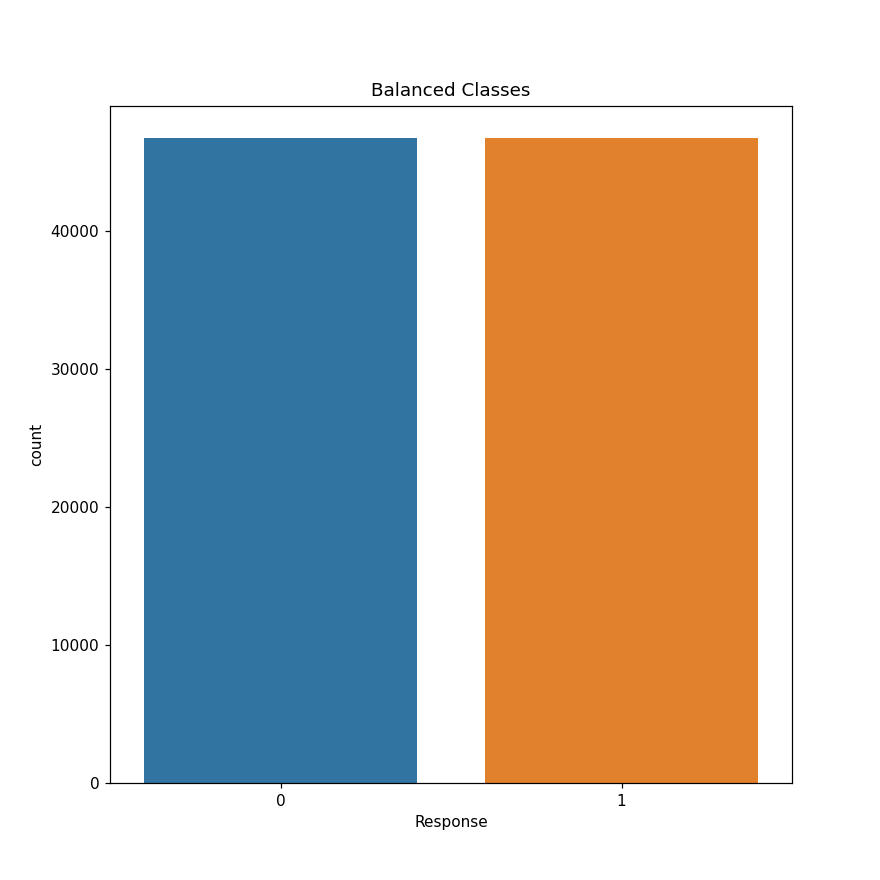

In [38]:

# Shuffle the Dataset.
shuffled_df = train.sample(frac=1,random_state=42)

# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['Response'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df['Response'] == 0].sample(n=46710,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('Response', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [67]:
normalized_df.head()
params = [i for i in normalized_df.columns if i not in ['id','Region_Code','Response','Annual_Premium','Age']]
trainx_norm,testx_norm,trainy_norm,testy_norm = train_test_split(normalized_df[params],normalized_df['Response'],test_size=0.10,random_state=42,shuffle=True)
model1 = LogisticRegression(C=1,max_iter=2000)

model1.fit(trainx_norm,trainy_norm)

predict_norm = model1.predict(testx_norm)
print(model1.score(testx_norm,testy_norm))
print(classification_report(testy_norm,predict_norm))

0.7792763862128024
              precision    recall  f1-score   support

           0       0.96      0.58      0.73      4670
           1       0.70      0.98      0.82      4672

    accuracy                           0.78      9342
   macro avg       0.83      0.78      0.77      9342
weighted avg       0.83      0.78      0.77      9342



# oversampling(SMOTE)

In [10]:
#using SMOTE(oversampling)

sm = SMOTE(sampling_strategy='minority', random_state=42)
oversampled_trainX, oversampled_trainY = sm.fit_sample(train.drop('Response', axis=1), train['Response'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
bins_over = pd.qcut(oversampled_train['Age'],5,[0,1,2,3,4])
oversampled_train['Age_bin'] = bins_over
params = [i for i in oversampled_train.columns if i not in ['id','Region_Code','Response','Annual_Premium','Age']]
trainx_over,testx_over,trainy_over,testy_over = train_test_split(oversampled_train[params],oversampled_train['Response'],test_size=0.10,random_state=42,shuffle=True)
model2 = LogisticRegression(C=1,max_iter=2000)

model2.fit(trainx_over,trainy_over)

predict_over = model2.predict(testx_over)
print(model2.score(testx_over,testy_over))
print(classification_report(testy_over,predict_over))

0.8173744019138756
              precision    recall  f1-score   support

           0       0.90      0.72      0.80     33287
           1       0.77      0.92      0.83     33593

    accuracy                           0.82     66880
   macro avg       0.83      0.82      0.82     66880
weighted avg       0.83      0.82      0.82     66880



In [80]:
#catboost
from catboost import CatBoostClassifier

cat_feature =['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage','Age_bin']

model3 = CatBoostClassifier(learning_rate=0.11,max_depth=7,n_estimators=1000,verbose=100,cat_features=cat_feature)
model3.fit(trainx_over,trainy_over)

predict_over_cat = model3.predict(testx_over)
print(model3.score(testx_over,testy_over))
print(classification_report(testy_over,predict_over_cat))

0:	learn: 0.5254703	total: 747ms	remaining: 12m 26s
100:	learn: 0.3267835	total: 49.6s	remaining: 7m 21s
200:	learn: 0.3259315	total: 1m 42s	remaining: 6m 47s
300:	learn: 0.3253457	total: 2m 29s	remaining: 5m 47s
400:	learn: 0.3248836	total: 3m 9s	remaining: 4m 43s
500:	learn: 0.3244983	total: 3m 49s	remaining: 3m 48s
600:	learn: 0.3240848	total: 4m 30s	remaining: 2m 59s
700:	learn: 0.3237513	total: 5m 16s	remaining: 2m 15s
800:	learn: 0.3233985	total: 6m 1s	remaining: 1m 29s
900:	learn: 0.3231213	total: 6m 41s	remaining: 44.1s
999:	learn: 0.3228834	total: 7m 22s	remaining: 0us
0.8350627990430622
              precision    recall  f1-score   support

           0       0.87      0.78      0.83     33287
           1       0.81      0.89      0.84     33593

    accuracy                           0.84     66880
   macro avg       0.84      0.83      0.83     66880
weighted avg       0.84      0.84      0.83     66880



<IPython.core.display.Javascript object>


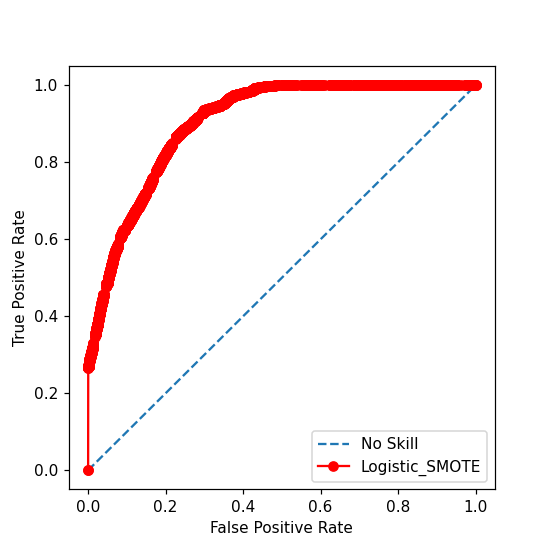

In [86]:
#performance curve(ROC)
from sklearn.metrics import roc_curve

yhat = model2.predict_proba(testx_over)
yhat1 = model3.predict_proba(testx_over)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
pos_probs1 = yhat1[:,1]
# calculate roc curve


# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, thresholds = roc_curve(testy_over, pos_probs)

# plot model roc curve
plt.plot(fpr, tpr, marker='o',color ='r',label='Logistic_SMOTE')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [97]:
#roc auc score
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(testy_over, pos_probs)
roc_cat = roc_auc_score(testy_over, pos_probs1)
print(f"Logistic roc_auc score is : {roc}")
print(f"Catboost roc_auc score is : {roc_cat}")

Logistic roc_auc score is : 0.903649931947365
Catboost roc_auc score is : 0.9232434955513655


In [99]:
#Hence catboost classifier perform well now we can use this model as final one.
model3.score(trainx_over,trainy_over)

0.8360358055416186

In [100]:
#dump model
pickle.dump(model3,open("cat_model.pkl",'wb'))

In [101]:
binn = pd.cut(oversampled_train['Age'],5)
binn

0           (33.0, 46.0]
1           (72.0, 85.0]
2           (46.0, 59.0]
3         (19.935, 33.0]
4         (19.935, 33.0]
               ...      
668793      (46.0, 59.0]
668794      (33.0, 46.0]
668795      (33.0, 46.0]
668796      (33.0, 46.0]
668797      (46.0, 59.0]
Name: Age, Length: 668798, dtype: category
Categories (5, interval[float64]): [(19.935, 33.0] < (33.0, 46.0] < (46.0, 59.0] < (59.0, 72.0] < (72.0, 85.0]]

In [103]:
min(oversampled_train['Age'])

20

In [12]:
trainx_over.head(2)

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,log_premium,Gender_premium,Vehicle_Damage_premium,Vehicle_Age_premium,Previously_Insured_premium,Age_bin
515183,0,1,0,2,1,10.339968,9.952826,9.952826,9.952826,9.962865,1
20301,1,1,0,2,1,11.054534,9.952826,9.952826,9.952826,9.962865,4
